# text2poem

### Aim
Given a textual description, generate a poem from it. 

### To-Do
- [ ] Clean up the variable names, etc
- [ ] Understand the T5 architecture and freeze the base layers if needed
- [ ] Create the $(\text{summary}, \ \text{poem})$ dataset using sites like [Poem Analysis](https://poemanalysis.com/). Ideally, smaller poems would be preffered. Might need to create manually, as scraping is not only difficult, but also lead to bad data. Stanza-by-Stanza is too detailed, and some summaries barely contain any information about the poem. Thus, data samples may need to be manually checked. Need to select famous poems that have good quality summaries available.
    - Doesn't work properly when tested with training set of $9$ poems, will need to try with more data
    - Another alternative, $(\text{topic}, \ \text{poem})$ dataset. Given a set of keywords, generate a poem. Dataset creation would be simple using LDA topic modelling etc.
        - [Topic Idenitification NLP 1](https://www.pluralsight.com/guides/topic-identification-nlp)
        - [Topic Idenitification NLP 2](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)
        - [Example](https://monkeylearn.com/keyword-extractor-online/)
- [ ] Clean the dataset, remove very long poems, if possible select by prominent authors, remove poems with no rhyming scheme.
- [ ] Change the RAKE algorithm
    - Maybe try using POS tagging in some way
- [ ] Check whether tokenizer preserves "\n" else replace by some other token
    - It's based on SentencePiece which doesn't preserve "\n"
- [ ] Calculate lengths of poems after data cleaning
### Ideas
- [ ] Rhyming scheme as T5 prefix

### References
- [Base code for this notebook](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb) (This had quite a few bugs) 
- [T5 finetuning tips](https://discuss.huggingface.co/t/t5-finetuning-tips/684/2)
- [T5 Docs](https://huggingface.co/transformers/model_doc/t5.html)
- [Training T5](https://huggingface.co/transformers/model_doc/t5.html#training) (Not detailed enough)
- [Finetuning T5](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb) (Probably the most extensive tutorial)
- [Few Shot Learning with T5](https://towardsdatascience.com/poor-mans-gpt-3-few-shot-text-generation-with-t5-transformer-51f1b01f843e)
- [Some Famous Poetry](https://medium.com/@EmEmbarty/31-of-the-best-and-most-famous-short-classic-poems-of-all-time-e445986e6df)
- [Poetry Summaries](https://www.litcharts.com/poetry/)
- [A great blog on how to generate text](https://huggingface.co/blog/how-to-generate)


## Install Dependencies

In [49]:
# Transformer changes very frequently, thus the version is important
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

## Connect to GDrive

In [50]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Start
To reset the notebook, run from this point

In [98]:
%reset -f

## Import Libraries

In [99]:
# General libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# The T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [100]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [101]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/poem_topics_200_top_authors.csv"
MODEL_NAME = "t5-small"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 512
SUMMARY_LEN = 512

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 10 # 5 is good enough for 5k samples in data
LR = 3e-4

In [102]:
# Set random seeds and make pytorch deterministic for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

## Helper Functions

In [103]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [104]:
def replaceSep(text, sep = " | "):
    if type(text) == float:
        print(text)
    return text.replace("\n", sep)

In [105]:
def loadDF(path, n_rows = None, split = 0.9,  prefix = "summarize: "):
    """ Loads the CSV data and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")
    df.dropna(inplace = True)
    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]
    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)
    # Add a suitable prefix to the text input
    df.input = prefix + df.input
    # Truncate the dataset if required
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    df["input"] = df["input"].apply(replaceSep, sep = ", ")
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, train_size = split, random_state = SEED, shuffle = True)
    
    if len(df_val) > 5:
        df_val = df_val[:5]

    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [106]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders, shuffle = False since we already shuffled once while creating the train-test split
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = False, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [107]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

In [108]:
# ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
# ds_train[0] # For quickly testing the data format

In [109]:
# temp = tokenizer(
#     ["hello\nmy friend* how| are|you today*haha"],
#     # max_length = self.inp_len, 
#     #padding = "max_length", 
#     #truncation = True,
#     return_tensors = "pt"
# ).input_ids
# ok = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in temp]
# print(ok)

## Train and Validate Functions:

In [110]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
                
        loss_batches.append(loss.item())
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss_batches

In [111]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [138]:
def generate(topics):

    input = "poetify: " + " , ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [142]:
def genSample(topics, min_length, max_length, rep_penalty):

    input = "poetify: " + ", ".join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        # temperature=0.7,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split("|")
    for s in sentences:
        print(s.strip())

    return gen

In [114]:
# gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"])

## Main

In [115]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [116]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = "poemify: ")
print(len(df), len(df_train), len(df_val))

487 438 5


In [117]:
display(df)

,output,input
0,"I have no wit, no words, no tears; | My heart ...","poemify: faded leaf, shall—the sap, mine eyes,..."
1,"A Bird, came down the Walk - | He did not know...","poemify: softer Home, frightened Beads, rapid ..."
2,My heart is like a singing bird | Whose nest i...,"poemify: hundred eyes, silver fleurs-de-lys, s..."
3,"You did not come, | And marching Time drew on,...","poemify: human deeds, dear presence, high comp..."
4,"Out of a fired ship, which by no way | But dro...","poemify: burnt ship, fired ship, drown, flame,..."
...,...,...
484,"Sweet and low, sweet and low, | Wind of the we...","poemify: western sea, dying, breathe, sleep, r..."
485,"Tears, idle tears, I know not what they mean, ...","poemify: first beam, half-awaken 'd, fancy fei..."
486,The splendour falls on castle walls | And snow...,"poemify: wild cataract, long light, rich sky, ..."
487,"Thy voice is heard thro' rolling drums, | That...","poemify: thy knee, thro, drums, battle, rollin..."


In [118]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

219 3


### Loading the Model

In [119]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [120]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [121]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [122]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}")
    loss_batches = train(e, tokenizer, model, dl_train, optimizer)
    losses += loss_batches

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10


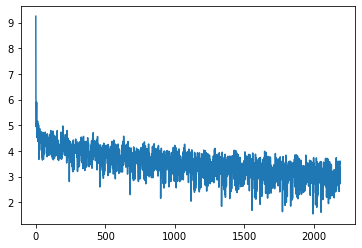

In [123]:
plt.plot(range(len(losses)), losses)
plt.show()

In [124]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [125]:
display(results)

,Generated Text,Actual Text
0,"I hear the tide moving away | From my home, an...","Sunset and evening star, | And one clear call ..."
1,"I am falling asleep in the cold world, | And w...","And did young Stephen sicken, | And did young ..."
2,"I have aspired to thee, | And in glorious ligh...",Ethereal minstrel! pilgrim of the sky! | Dost ...
3,"I have a pleasant lot of charmed sleep, | And ...",Where sunless rivers weep | Their waves into t...
4,"I hear the throstle sing, | And whispering to ...","Up! up! my Friend, and quit your books; | Or s..."


In [132]:
x = 3
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

I have a pleasant lot of charmed sleep, | And the sun is warm and cold; but it has not been so much. 

Where sunless rivers weep | Their waves into the deep, | She sleeps a charmed sleep: | Awake her not. | Led by a single star, | She came from very far | To seek where shadows are | Her pleasant lot. | | She left the rosy morn, | She left the fields of corn, | For twilight cold and lorn | And water springs. | Through sleep, as through a veil, | She sees the sky look pale, | And hears the nightingale | That sadly sings. | | Rest, rest, a perfect rest | Shed over brow and breast; | Her face is toward the west, | The purple land. | She cannot see the grain | Ripening on hill and plain; | She cannot feel the rain | Upon her hand. | | Rest, rest, for evermore | Upon a mossy shore; | Rest, rest at the heart's core | Till time shall cease: | Sleep that no pain shall wake; | Night that no morn shall break | Till joy shall overtake | Her perfect peace.


In [145]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.4)

The wind is red —
I am rustling the forest and dasolate in the rain;
If only the snow is weeping it, what will be?
A tree should come from the bush.
And that’s what could be without its arrivment:
This would not mean she died by her neck!
No further or worse than the wind was demolishing it.
Wereping there through the day,
You were seen dancing out of the wood and driving up forests.


In [147]:
gen = genSample(["happy", "elated smile", "good luck", "persian rugs", "beautiful eyes"], 100, 500, 1.3)

This is the love of a smile that should see him,
The love of a man who will read his books,
And sing to me in an elated smile.
It seems like he feels happy enough; but this is what he says's good luck for you:

To speak on persian carpets and where they lie
In their splendor alone
Should be one whom I loved only with her true joy
With the scepticism that must take place.


In [151]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.3)

"How have you dream that joyous smile?
Do you want to write it in the elated smile, then see its glowing sun and smile?"
What is your mood of happiness with an elated smile?
I love that passion for dancing trees?
Or perhaps you will come along with others as lovers?
For now you are ready to start cheering on yourself.
No more can you draw your voice from my dancing trees.
Be like a glowing sun or smile, who should make the same;
Perhaps something else! It grows up in the rising trees
To look upon me at me'd him after the noises out.


In [154]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.4)

Once again, a joyous smile by the sun to hang him in his tongues
As though it felt like he was dancing trees.
They said that this glowing sun is not all:
The stars look too happy and bright for their fans!
And who would have be happy with their faces?
Their cheer might be full of laughter but some doppling leaves.
From the dancing trees they think there are lots more;
But what happened to this elated smile today I never met.


In [156]:
gen = genSample(["hoary sky", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.2)

To be tired like the sheep,
Besides the hoary sky I will be taking.
For this long time of years
With all these very odd animals being taken,
And we are tired by what is done now,
How can you take it over and walk away?
The young men start to get away in amazement from their homes
And out of the stable light of summer.
But when we have spent our lives doing they stand alone too soon!
That would lead us thinking for a while:
But then with more to play,
And that the dogs could not watch or draw so tired;
For those who are tired as though they will move back together and cry
A man is on the verge of living's mind
Should ye find no consensus
Of the hoary sky again must be taken,
You seek such a side up-and-hope.


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```